In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#add project root to path
project_root = os.path.abspath("..")
sys.path.append(project_root)

#custom modules
import src.data_processing as dp
import src.visualization as vz
from src.models import RegressionModel

#create figures folder if it doesn't exist
os.makedirs("../reports/figures", exist_ok=True)

In [ ]:
#load the cleaned dataset
house_df = dp.load_csv('../data/housing_data_cleaned.csv')
print("Cleaned dataset shape:", house_df.shape)

#feature selection
numeric_features = dp.get_numeric_features(house_df)
X = numeric_features.drop(columns=["SalePrice", "SalePrice_log"], errors='ignore')
y = house_df["SalePrice_log"]  # log-transformed target

print("\nSelected features for ML models:")
print(X.columns)

In [ ]:
#initialize models
model_names = ["linear", "decision_tree", "random_forest"]
models = {name: RegressionModel(model_name=name) for name in model_names}


#train, predict, evaluate
results = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    
    #split the data
    model.train_test_split(X, y, test_size=0.2)
    
    #train the model
    model.train()
    
    #predict on test set
    y_pred = model.predict()
    
    #evaluate
    metrics = model.evaluate()
    results[name] = metrics
    
    #summary
    model.summary()

Cleaned dataset shape: (2930, 87)

Selected features for ML models:
Index(['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold',
       'Total House Area', 'Has Garage', 'Has Basement', 'Has Fireplace'],
      dtype='object')

Training linear model...
Model: linear
R2: 0.9037
MSE: 0.0178

Training decision_tree model...
Model: decision_tree
R2: 0.8376
MSE: 0.0300

Training random_forest model...
Model: random_forest
R2: 0.9152


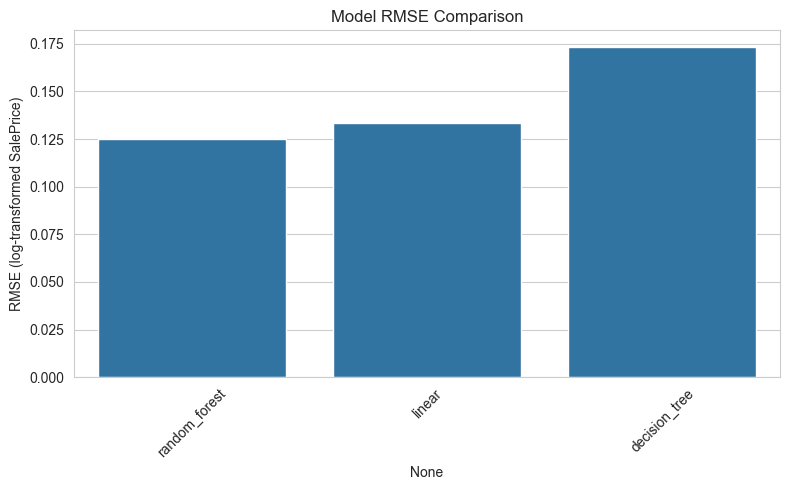


Top 10 important features (Random Forest):
             Feature  Importance
5       Overall Qual    0.490056
38  Total House Area    0.286630
7         Year Built    0.020360
27       Garage Cars    0.020094
8     Year Remod/Add    0.017432
26     Garage Yr Blt    0.016341
17       Gr Liv Area    0.016054
4           Lot Area    0.015591
28       Garage Area    0.013978
10      BsmtFin SF 1    0.011163


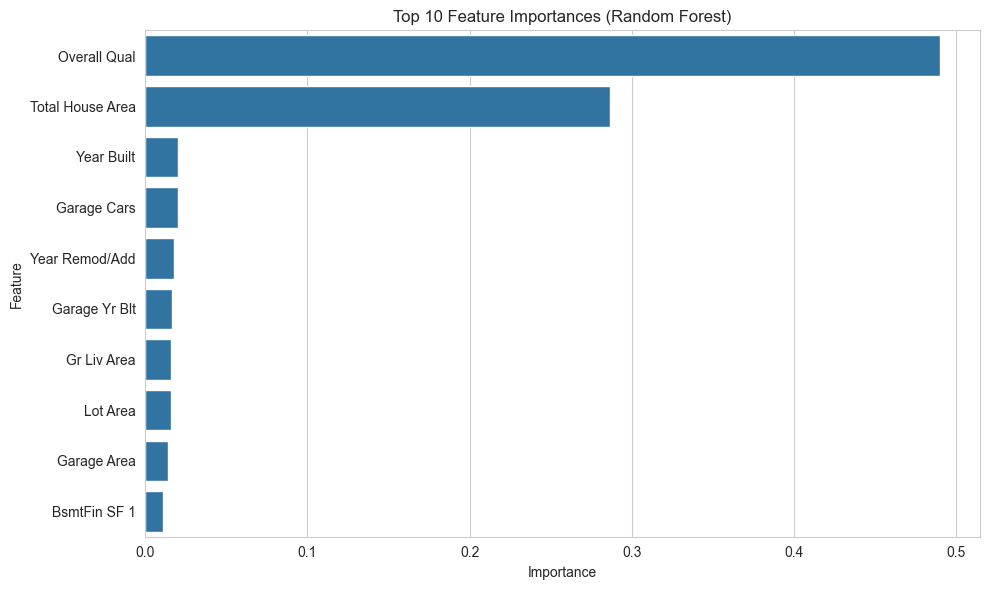

Random Forest predictions saved to predictions_rf.csv


In [2]:
#Compare model performance
results_df = pd.DataFrame(results).T
results_df = results_df.rename(columns={"MSE": "RMSE"})
results_df["RMSE"] = np.sqrt(results_df["RMSE"])  # convert MSE to RMSE
results_df = results_df.sort_values(by="RMSE")

print("\nModel performance comparison:")
print(results_df)

#bar chart of RMSE
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y="RMSE", data=results_df.reset_index())
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE (log-transformed SalePrice)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../reports/figures/model_rmse_comparison.png")
plt.show()


#Random Forest feature importance

rf_model = models["random_forest"].model  # access sklearn model directly
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 important features (Random Forest):")
print(feature_importance_df.head(10))

sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("../reports/figures/rf_feature_importance.png")
plt.show()

# --------------------------
# 7️⃣ Optional: Save predictions
# --------------------------
predictions_df = pd.DataFrame({
    "Actual_SalePrice_log": models["random_forest"].y_test,
    "Predicted_SalePrice_log": models["random_forest"].y_pred
})
dp.save_csv(predictions_df, "../data/predictions_rf.csv")
print("Random Forest predictions saved to predictions_rf.csv")